# EDA Augmented Segmentation Dataset

## Contents:
### I. Data augmentation techniques:
### II. Augmented data statistics:
-    1. Example of augmented data and label mask.
-    2. Number data in Augmented Segmentation Dataset.
-    3. Train–Validation Split Statistics.

In [27]:
from ultralytics import YOLO
import os
import torch
from matplotlib import pyplot as plt
import cv2
import numpy as np
import json
from matplotlib import cm
from matplotlib.patches import Patch
from collections import Counter

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce GTX 1650


## I. Data augmentation techniques:

This is the original image:

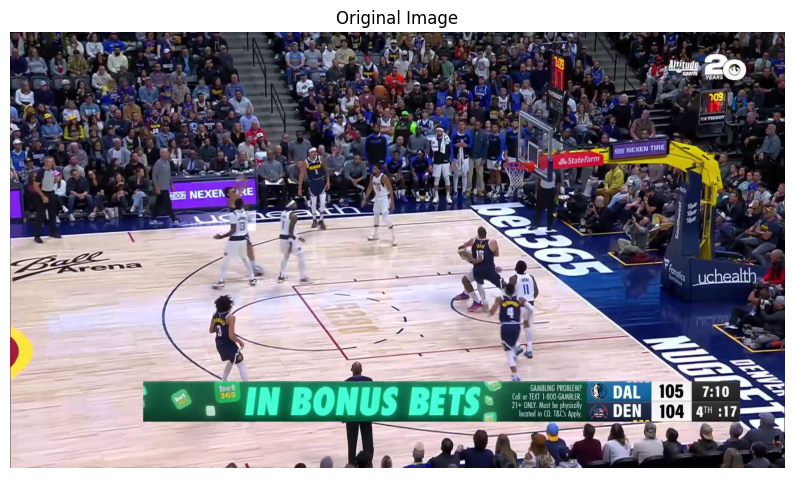

In [4]:
"""
Script: display_image_rgb.py

Purpose:
    - Load an image from disk, convert it from OpenCV's default BGR to RGB,
      and display it using Matplotlib without axes.

Inputs:
    - original_img: Path to the image file.

Outputs:
    - A Matplotlib window showing the image (no axes), titled "Original Image".
"""

# === CONFIGURATION ===
original_img = r"dataset\images\val\Maericks_Nuggets_1305_Thunv10_001404.jpg"

# === LOAD IMAGE (OpenCV reads in BGR) ===
img = cv2.imread(original_img)
if img is None:
    raise FileNotFoundError(f"Cannot read image from: {original_img}")

# Convert to RGB for correct color display with Matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === DISPLAY ===
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()


Step 1: We will insert more augmented logo in this image but not on the playing field.

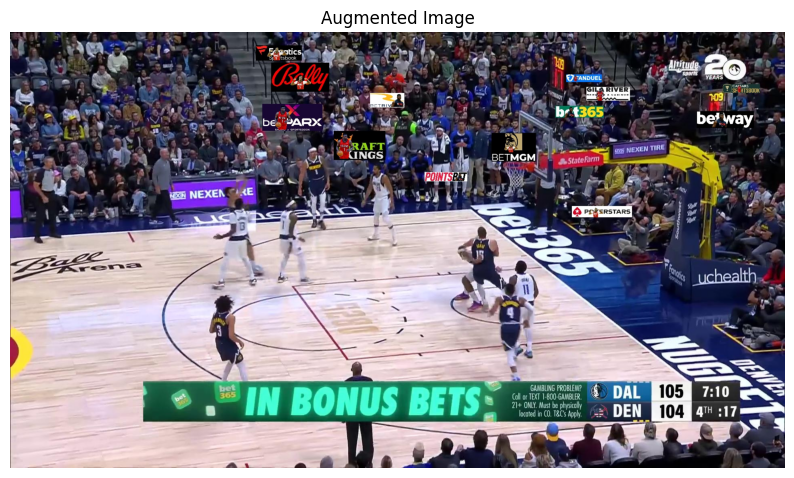

In [ ]:
"""
Script: display_augmented_image.py

Purpose:
    - Load an augmented image from disk, convert from OpenCV's default BGR to RGB,
      and display it with Matplotlib (axes hidden).

Inputs:
    - original_img: Path to the augmented image file.

Outputs:
    - A Matplotlib window showing the image titled "Augmented Image".
"""

# === CONFIGURATION ===
original_img = r"dataset\images\Train\Aug_Maericks_Nuggets_1305_Thunv10_001404.jpg"

# === LOAD IMAGE (OpenCV reads BGR) ===
img = cv2.imread(original_img)
if img is None:
    raise FileNotFoundError(f"Cannot read image from: {original_img}")

# Convert to RGB for correct color display in Matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === DISPLAY ===
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Augmented Image")
plt.show()


Step 2: We insert those logo's label into original json file.

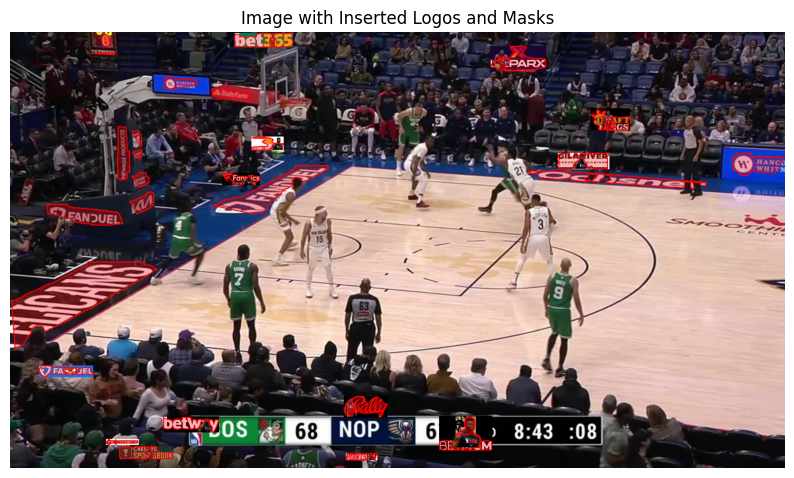

In [9]:
"""
Script: visualize_yolov8_seg_masks.py

Purpose:
    - Read an image and its YOLO segmentation label file, then draw semi-transparent
      polygon masks over the image for visualization.

Supports:
    - YOLOv8-Seg format with bbox + polygon:
        class cx cy w h x1 y1 x2 y2 ...
    - Polygon-only lines (no bbox), if present:
        class x1 y1 x2 y2 ...

Inputs:
    - image_path: Path to the image file.
    - label_path: Path to the YOLO segmentation .txt file.

Outputs:
    - A Matplotlib window showing the image with overlaid masks and outlines.
"""

# === CONFIGURATION ===
image_path = r"data_aug_txt\Aug_Jayson_Tatum_1605_khaihoan2003_000512.jpg"
label_path = r"data_aug_txt\Aug_Jayson_Tatum_1605_khaihoan2003_000512.txt"


# === FUNCTION: LOAD AND DRAW TRANSLUCENT MASKS ===
def load_and_draw_yolo_segment(image_path: str, label_path: str, alpha: float = 0.3):
    """
    Load an image and its YOLO segmentation labels, then overlay translucent polygon masks.

    Args:
        image_path (str): Path to the image.
        label_path (str): Path to the YOLO segmentation label file (.txt).
        alpha (float):    Transparency factor for filled masks (0.0–1.0).

    Returns:
        np.ndarray: The RGB image with masks blended and polygon outlines drawn.

    Notes:
        - This function attempts to parse both YOLOv8-Seg (bbox + polygon) and
          polygon-only formats. If a line cannot be parsed into valid (x, y)
          pairs, it will be skipped.
    """
    # Load image (OpenCV loads as BGR; convert to RGB for display)
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Cannot read image from: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Create an overlay for filled polygons (keeps the base image sharp for outlines)
    overlay = img.copy()

    # Read label lines
    with open(label_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    for line in lines:
        tokens = line.strip().split()
        if not tokens:
            continue

        # First token must be class_id
        try:
            class_id = int(tokens[0])
        except ValueError:
            continue

        # Remaining tokens are floats (either bbox+polygon or polygon-only)
        try:
            vals = [float(x) for x in tokens[1:]]
        except ValueError:
            continue

        # Decide parsing strategy:
        # If we have at least 10 numbers AND (len - 4) is even -> assume bbox + polygon.
        # Else if total is even -> assume polygon-only.
        coords = None
        if len(vals) >= 10 and (len(vals) - 4) % 2 == 0:
            # YOLOv8-Seg: cx cy w h + poly
            xy = vals[4:]
            coords = np.array(xy, dtype=float).reshape(-1, 2)
        elif len(vals) >= 6 and len(vals) % 2 == 0:
            # Polygon-only
            coords = np.array(vals, dtype=float).reshape(-1, 2)

        if coords is None or coords.shape[0] < 3:
            # Not enough points to form a polygon
            continue

        # Denormalize polygon coordinates to pixel space
        coords[:, 0] *= w  # x
        coords[:, 1] *= h  # y
        coords = coords.astype(np.int32)

        # Fill polygon on the overlay (semi-transparent after blending)
        cv2.fillPoly(overlay, [coords], color=(255, 0, 0))  # red fill on overlay

        # Draw crisp polygon outline on the (non-blended) base image
        cv2.polylines(img, [coords], isClosed=True, color=(255, 0, 0), thickness=2)

    # Blend overlay with the base image to get translucent masks
    blended = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    return blended


# === DISPLAY RESULT ===
vis_img = load_and_draw_yolo_segment(image_path, label_path, alpha=0.3)
plt.figure(figsize=(10, 10))
plt.imshow(vis_img)
plt.axis("off")
plt.title("Image with Inserted Logos and Masks")
plt.show()


## II. Augmented data statistics:

### 1. Example of augmented data and label mask.

C:\Users\pchau\AppData\Local\Temp\ipykernel_6684\767385326.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")  # 20 distinct colors


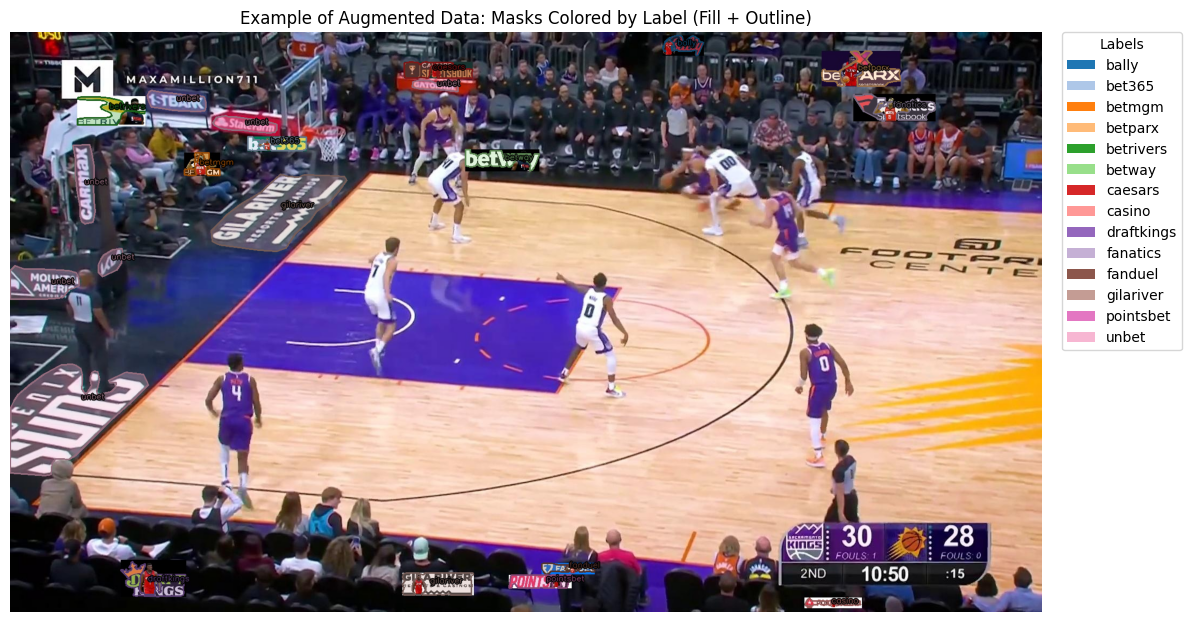

In [26]:
"""
Script: visualize_labelme_masks.py

Purpose:
    - Load a LabelMe JSON and its corresponding image.
    - Color each polygon mask by label (distinct color per label).
    - Draw darker outlines and (optional) label names at polygon centroids.
    - Show a legend mapping labels to colors.

Inputs:
    - image_path: Path to the image file.
    - json_path:  Path to the LabelMe JSON file describing shapes/polygons.

Outputs:
    - A matplotlib window displaying the blended masks and outlines.
    - (Optional) You can save the figure with plt.savefig("output.png", dpi=200, bbox_inches="tight").

Requirements:
    - Python 3.x
    - OpenCV (cv2), NumPy, Matplotlib
"""

# === PATHS ===
image_path = r"data_aug_json\Aug_PhoenixSuns_vs_SanAntonio Spurs_1305_Thunv10_0272.jpg"
json_path  = r"data_aug_json\Aug_PhoenixSuns_vs_SanAntonio Spurs_1305_Thunv10_0272.json"

# === LOAD IMAGE (RGB for consistent coloring) ===
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Cannot read image: {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === CREATE OVERLAY FOR FILLS (keeps original image intact) ===
overlay = image.copy()

# === LOAD LABELME JSON ===
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

shapes = data.get("shapes", [])
if not shapes:
    raise ValueError("No shapes found in JSON.")

# === BUILD A COLOR MAP: label -> RGB (using matplotlib's tab20) ===
unique_labels = sorted({s.get("label", "") for s in shapes if s.get("label")})
cmap = cm.get_cmap("tab20")  # 20 distinct colors
label2color = {}
for i, lb in enumerate(unique_labels):
    r, g, b, _ = cmap(i % 20)  # floats in [0, 1]
    label2color[lb] = (int(r * 255), int(g * 255), int(b * 255))  # convert to 0–255 RGB

def darker(rgb, factor=0.6):
    """Return a darker variant of an RGB color for crisp polygon outlines."""
    return tuple(max(0, int(c * factor)) for c in rgb)

# === DRAW FILLED POLYGONS ON THE OVERLAY ===
for shape in shapes:
    label  = shape.get("label", "")
    points = np.array(shape.get("points", []), dtype=np.int32)

    # Skip invalid/non-polygon shapes
    if points.ndim != 2 or points.shape[0] < 3:
        continue

    fill_color = label2color.get(label, (255, 0, 0))  # fallback to red if label missing
    cv2.fillPoly(overlay, [points], color=fill_color)

# === BLEND OVERLAY WITH THE ORIGINAL IMAGE ===
alpha = 0.3  # transparency of fills (0: transparent, 1: opaque)
blended = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

# === DRAW OUTLINES AND OPTIONAL LABEL TEXT ON TOP (sharp, non-blended) ===
for shape in shapes:
    label  = shape.get("label", "")
    points = np.array(shape.get("points", []), dtype=np.int32)

    if points.ndim != 2 or points.shape[0] < 3:
        continue

    # Outline color: a darker version of the fill color
    edge_color = darker(label2color.get(label, (255, 0, 0)), 0.6)
    cv2.polylines(blended, [points], isClosed=True, color=edge_color, thickness=2)

    # Optional: place label text near the polygon centroid (with black outline for readability)
    cx, cy = np.mean(points, axis=0).astype(int)
    cv2.putText(blended, label, (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(blended, label, (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, edge_color, 1, cv2.LINE_AA)

# === BUILD LEGEND (label-color mapping) ===
legend_handles = [
    Patch(facecolor=np.array(label2color[l]) / 255.0, edgecolor='none', label=l)
    for l in unique_labels
]

# === DISPLAY ===
plt.figure(figsize=(12, 12))
plt.imshow(blended)
plt.axis('off')
plt.title("Example of Augmented Data: Masks Colored by Label (Fill + Outline)")
if legend_handles:
    plt.legend(handles=legend_handles, title="Labels",
               bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()


### 2. Number data in Augmented Segmentation Dataset.

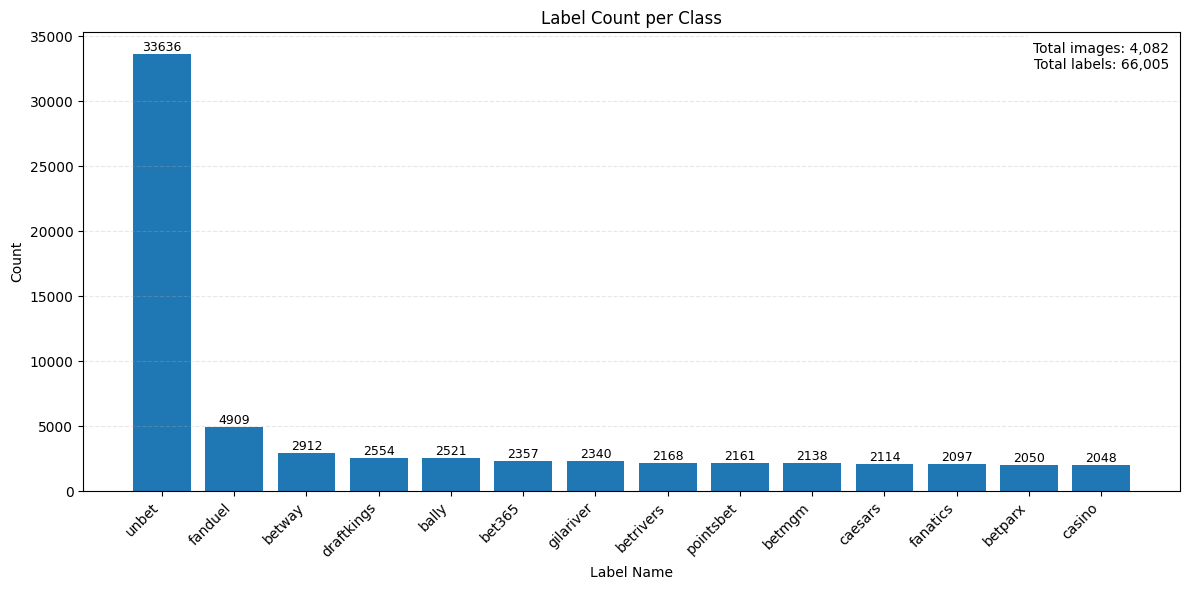

In [29]:
"""
Script: label_count_bar_chart.py
Purpose:
    - Parse LabelMe JSON files and count annotations per label.
    - Draw a bar chart showing counts for each label.
    - Display the total number of images (JSON files) and total labels (annotations) in the top-right corner.

Inputs:
    - folder_path: Root directory containing LabelMe JSON files (recursively).

Outputs:
    - A matplotlib bar chart (on screen if plt.show() is called).
    - (Optional) You can save the figure by calling plt.savefig("label_counts.png", dpi=200, bbox_inches="tight").

Requirements:
    - Python 3.x
    - matplotlib
"""

# === CONFIGURATION ===
folder_path = "data_aug_json"  # Root directory containing LabelMe JSON files

# === STATE ===
label_counter = Counter()
images_processed = 0  # Number of JSON files successfully read (treated as number of images)

# === WALK ALL JSON FILES (RECURSIVE) ===
for root, _, files in os.walk(folder_path):
    for filename in files:
        if filename.lower().endswith(".json"):
            json_path = os.path.join(root, filename)
            try:
                with open(json_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                images_processed += 1

                # Count label occurrences in each JSON's "shapes"
                for shape in data.get("shapes", []):
                    label = shape.get("label")
                    if label:
                        label_counter[label] += 1
            except Exception as e:
                print(f"Error reading {filename}: {e}")

# === EXIT EARLY IF NO DATA FOUND ===
if not label_counter:
    print("No labels found in the provided JSON directory.")
else:
    # Sort labels by count (descending) for clearer visualization
    labels, counts = zip(*label_counter.most_common())
    total_labels = sum(counts)  # Total number of annotations across all files

    # === PLOT BAR CHART ===
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    bars = ax.bar(range(len(labels)), counts)

    # Axes labels and title
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Count")
    ax.set_xlabel("Label Name")
    ax.set_title("Label Count per Class")

    # Annotate each bar with its value
    for bar, cnt in zip(bars, counts):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{cnt}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    # Show totals in the top-right corner
    ax.text(
        0.99, 0.98,
        f"Total images: {images_processed:,}\nTotal labels: {total_labels:,}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.85, edgecolor="none")
    )

    # Light horizontal gridlines for readability
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    # Optional:
    # plt.savefig("label_counts.png", dpi=200, bbox_inches="tight")
    # plt.show()


Status:
- Classes with missing data have been filled in with argument techniques.
- We kept the ratio of data between 'unbet' and other classes close to reality without being completely balanced because we wanted our segmentation model to be able to segment almost all logos appearing on the frame.

### 3. Train–Validation Split Statistics.

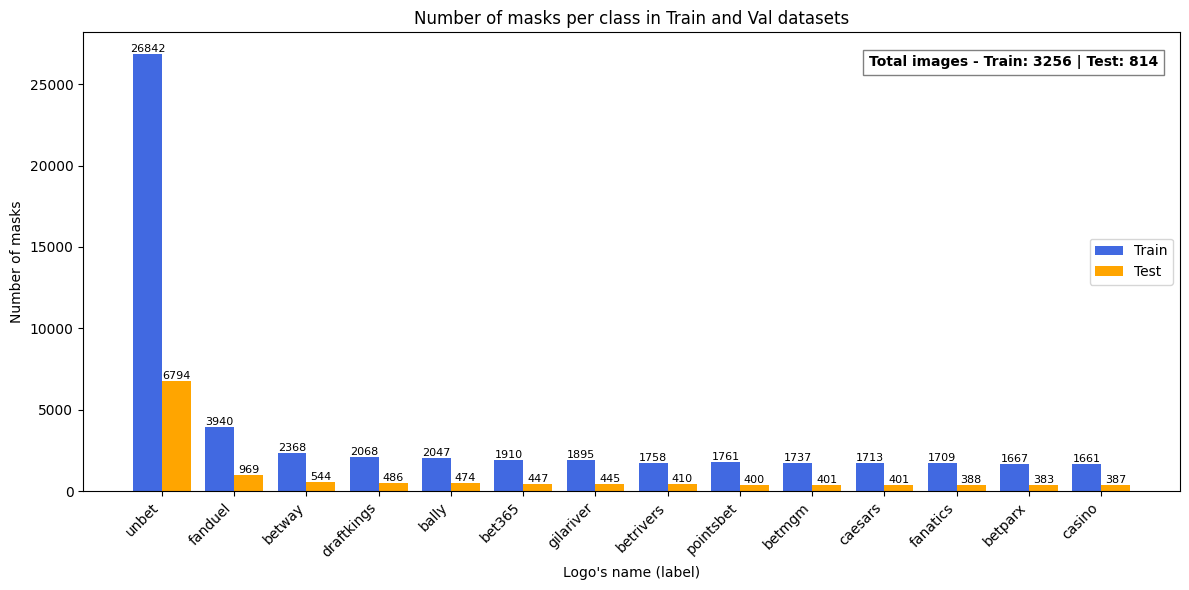

In [5]:
import os
import json
from collections import Counter
import matplotlib.pyplot as plt

# === CẤU HÌNH ===
train_folder_path = r"data_split_json/train"
test_folder_path = r"data_split_json/val"

def count_labels_in_folder(folder_path):
    label_counter = Counter()
    image_count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            json_path = os.path.join(folder_path, filename)
            try:
                with open(json_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    has_label = False
                    for shape in data.get("shapes", []):
                        label = shape.get("label")
                        if label:
                            label_counter[label] += 1
                            has_label = True
                    if has_label:
                        image_count += 1
            except Exception as e:
                print(f"Lỗi khi đọc {filename}: {e}")
    return label_counter, image_count

# === ĐẾM LABEL CHO TRAIN & TEST ===
train_labels, train_images = count_labels_in_folder(train_folder_path)
test_labels, test_images = count_labels_in_folder(test_folder_path)

# === TỔNG HỢP DANH SÁCH NHÃN ===
all_labels = sorted(set(train_labels.keys()) | set(test_labels.keys()))

# Sắp xếp nhãn theo tổng số mask (train + test) giảm dần
sorted_labels = sorted(all_labels, key=lambda lbl: train_labels.get(lbl, 0) + test_labels.get(lbl, 0), reverse=True)

train_counts = [train_labels.get(label, 0) for label in sorted_labels]
test_counts = [test_labels.get(label, 0) for label in sorted_labels]

# Vẽ lại biểu đồ như cũ nhưng với sorted_labels
x = range(len(sorted_labels))
bar_width = 0.4

plt.figure(figsize=(12, 6))
bars1 = plt.bar([i - bar_width/2 for i in x], train_counts, width=bar_width, label="Train", color='royalblue')
bars2 = plt.bar([i + bar_width/2 for i in x], test_counts, width=bar_width, label="Test", color='orange')

# Gắn số lượng lên cột
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=8)

# Gắn tổng số ảnh
plt.text(0.98, 0.95, f"Total images - Train: {train_images} | Test: {test_images}",
         transform=plt.gca().transAxes, ha='right', va='top', fontsize=10, fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='gray'))

plt.ylabel("Number of masks")
plt.xlabel("Logo's name (label)")
plt.title("Number of masks per class in Train and Val datasets")
plt.xticks(x, sorted_labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()



- We still split the data using the technique of keeping the ratio between classes and keep the ratio 8/2 for the two train and val sets.
- This division ensures that the training and evaluation process will be effective overall.